In [28]:
# some useful keepa time series attributes
keepa_idxes = {1: 'NEW', 2: 'USED', 18: 'BUY_BOX',
               28: 'EBAY_NEW', 29: 'EBAY_USED'}

Read cpu table from amazon.db

In [29]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


db = sqlite3.connect('../../data/amazon.db')

cpu_df = pd.read_sql('select * from cpu', db)
cpu_df.head()

,asin,catagory,manufacturer,brand,model_name,product_name,last_update
0,B07YP67PFV,cpu,Intel,Intel,core i9-10940X,Intel Core i9-10940X Desktop Processor 14 Core...,5616932
1,B07YP6Y9VY,cpu,Intel,Intel,core i9-10920X,Intel Core i9-10920X Desktop Processor 12 Core...,5616932
2,B07YP69HTM,cpu,Intel,Intel,core i9-10900X,Intel Core i9-10900X Desktop Processor 10 Core...,5616932
3,B07JGCMQY8,cpu,D&H,Intel,core i9-9980XE,Intel Core i9-9980XE Extreme Edition Processor...,5616904
4,B07JFH771Y,cpu,D&H,Intel,core i9-9940X,Intel Core i9-9940X X-Series Processor 14 Core...,5616932


Query the first asin in cpu_ts table with keepa_idx = 1.

In [30]:
first_asin = cpu_df['asin'][0]
cpu_ts_1 = pd.read_sql_query(f'select keepa_minute, value1 from cpu_ts where asin = "{first_asin}" and keepa_idx=1', db)
cpu_ts_1.head()

,keepa_minute,value1
0,4681356,-1
1,4724176,93354
2,4725626,87090
3,4725944,97188
4,4726372,-1


Convert keepa_minute to timestamp.

In [31]:
cpu_ts_1['ts'] = pd.to_datetime((cpu_ts_1['keepa_minute'] + 21564000) * 60, unit='s')
cpu_ts_1.head()

,keepa_minute,value1,ts
0,4681356,-1,2019-11-25 22:36:00
1,4724176,93354,2019-12-25 16:16:00
2,4725626,87090,2019-12-26 16:26:00
3,4725944,97188,2019-12-26 21:44:00
4,4726372,-1,2019-12-27 04:52:00


Take a look at the distribution of time interval in this time series.

<AxesSubplot:ylabel='Count'>

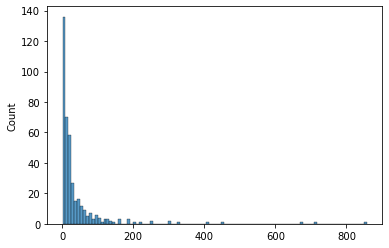

In [32]:
import numpy as np

intervals = (cpu_ts_1['ts'].values[1:] - cpu_ts_1['ts'].values[:len(cpu_ts_1) - 1])  / np.timedelta64(1, 'h')
sns.histplot(intervals)

Then set ts column as index.

In [33]:
cpu_ts_1.set_index('ts', inplace=True)

Draw plots of the raw data.

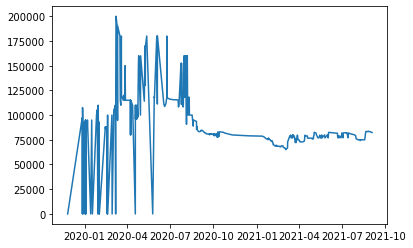

In [34]:
plt.plot(cpu_ts_1.index, cpu_ts_1['value1'])

We use 1h(3600s) as the smoothing interval to upsample the time series.

In [35]:
cpu_ts_1_1h = cpu_ts_1.resample('1H').pad()
cpu_ts_1_1h.head()

,keepa_minute,value1
ts,,
2019-11-25 22:00:00,NaN,NaN
2019-11-25 23:00:00,4681356.0,-1.0
2019-11-26 00:00:00,4681356.0,-1.0
2019-11-26 01:00:00,4681356.0,-1.0
2019-11-26 02:00:00,4681356.0,-1.0


Draw plots of the equal-interval data.

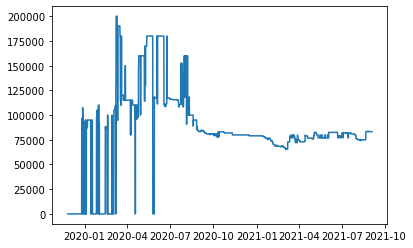

In [36]:
plt.plot(cpu_ts_1_1h.index, cpu_ts_1_1h['value1'])

Try 1 day as resample interval

In [37]:
cpu_ts_1_1d = cpu_ts_1.resample('1D').ffill()
cpu_ts_1_1d.head()

,keepa_minute,value1
ts,,
2019-11-25,NaN,NaN
2019-11-26,4681356.0,-1.0
2019-11-27,4681356.0,-1.0
2019-11-28,4681356.0,-1.0
2019-11-29,4681356.0,-1.0


Draw plots of the equal-interval data.

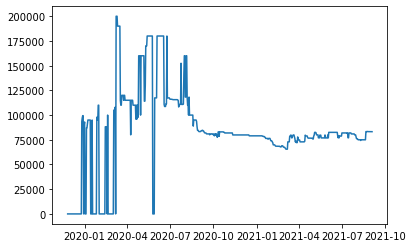

In [38]:
plt.plot(cpu_ts_1_1d.index, cpu_ts_1_1d['value1'])

Then we read all products.

In [39]:
gpu_df = pd.read_sql('select * from gpu', db)
dr_df = pd.read_sql('select * from drive', db)

Resample time series and save to file.

In [40]:
def resample_1d(table, asin, keepa_idx):
    ts = pd.read_sql_query(f'select keepa_minute, value1 from {table} where asin = "{asin}" and keepa_idx={keepa_idx}', db)
    ts['ts'] = pd.to_datetime((ts['keepa_minute'] + 21564000) * 60, unit='s')
    ts.drop(['keepa_minute'], axis=1, inplace=True)
    ts.set_index('ts', inplace=True)
    ts = ts.resample('1D').ffill().dropna()
    return ts

for idx, name in keepa_idxes.items():
    label_files = {t: open(f'../../data/amazon/{name}_label_{t}.txt', 'w') for t in ['s', '6m', '1y', '2y', '4y']}
    ts_files = {t: open(f'../../data/amazon/{name}_ts_{t}.txt', 'w') for t in ['s', '6m', '1y', '2y', '4y']}
    def process(df, table_name, category, info_list):
        for _, row in df.iterrows():
            ts_df = resample_1d(table_name, row['asin'], idx)
            v1 = [str(int(v)) for v in ts_df['value1']]
            label = ' '.join([category] + [row[info] for info in info_list])
            ts = ' '.join(v1)
            if len(v1) >= 1440:
                time_range = '4y'
            elif len(v1) >= 720:
                time_range = '2y'
            elif len(v1) >= 360:
                time_range = '1y'
            elif len(v1) >= 180:
                time_range = '6m'
            elif len(v1) > 10:
                time_range = 's'
            else:
                # if time series less than 10 days, drop it
                continue
            label_files[time_range].write(label)
            label_files[time_range].write('\n')
            ts_files[time_range].write(ts)
            ts_files[time_range].write('\n')
    process(cpu_df, 'cpu_ts', 'cpu', ['brand', 'model_name'])
    process(gpu_df, 'gpu_ts', 'gpu', ['brand', 'model_name'])
    process(dr_df, 'drive_ts', 'drive', ['brand', 'model_name', 'drive_subtype', 'capacity'])

    [f.close() for _, f in label_files.items()]
    print(f'Save labels to {name}')
    [f.close() for _, f in ts_files.items()]
    print(f'Save time series to {name}')

Save labels to NEW
Save time series to NEW
Save labels to USED
Save time series to USED
Save labels to BUY_BOX
Save time series to BUY_BOX
Save labels to EBAY_NEW
Save time series to EBAY_NEW
Save labels to EBAY_USED
Save time series to EBAY_USED


Close database connection.

In [41]:
db.close()